# Bandstructure of the twpa
This is a notebook dedicated to calculate the dispersion relation of the squid-array twpa. All the calculation presented here are inspired by the theory developped by Erickson and Pappas in their article "Theory of multiwave mixing within the superconducting kinetic-inductance traveling-wave amplifier" available here https://arxiv.org/pdf/1612.00365.pdf.

First we define the periodic loading of our twpa using the different parameters provided in the Erickson paper.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

The equivalent circuit we will use is plotted below. The amplifier consists in periodic cells of lenght $l_0$ built on unit cells of lenght a in such a way that $l_0 = Na$. The periodicity of the network is contained into the values of L and C. $L(x + l_0)= L(x)$ and $C(x + l_0) = C(x)$. 

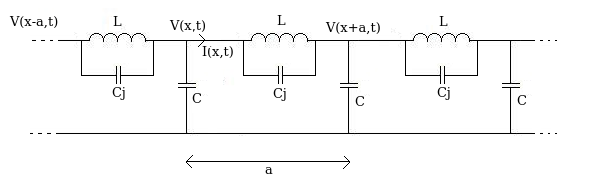

In [3]:
twpa = Image(filename = './schemes/twpa1.jpg')
twpa

In [74]:
R = 7                #Number of regions
l0 = 565          #Unit cell length in µm

Lr = np.array([0.10, 0.20, 0.50, 0.55, 0.50, 0.20, 0.10])                   #Inductance per unit length in pH/µm
Cr = np.array([0.745, 0.745, 0.745, 0.745, 0.745, 0.745, 0.745])            #Capacitance per unit length in fF/µm
dx = np.array([l0/7, l0/7, l0/7, l0/7, l0/7, l0/7, l0/7])                         #Lengths of the loaded regions in µm
r = np.array([1, 2, 3, 4, 5, 6, 7]) 
a = l0/R

In [75]:
l0 = l0*10**(-6)       #In m
Lr = Lr*10**(-6)       #In H/m
Cr = Cr*10**(-9)       #In F/m
dx = dx*10**(-6)     #In m
a  = a*10**(-6)      #in m
Cj = 0.540*10**(-9)  #in F/m

All this part is dedicated to the calculation of the dispersion matrix as defined in eq (23).

$D_{n,n'} = \frac{1}{L_{(R+1)/2}C_{(R+1)/2}}(k + \frac{2\pi n}{l_0})²\delta_{n,n'} + [\mathcal{D}_{n-n'}(\{L_r\}\{C_r\})(k + \frac{2\pi n}{l_0}) + \mathcal{D}_{n-n'}(\{C_r\}\{L_r\})(k + \frac{2\pi n'}{l_0})](k + \frac{2\pi n'}{l_0})$

Where the $\mathcal{D}_{n}$ coefficients are defined in eqution (24) by

$\mathcal{D}_{n}(\{L_r\}\{C_r\}) = \frac{1}{2\pi n}\sum_{r=1}^{(R-1)/2}(\frac{1}{L_r} + \frac{1}{L_{r+1}})(\frac{1}{C_r} - \frac{1}{C_{r+1}})\sin(2\pi\sum_{r'=1}^{r}\Delta x_{r'}n/l_0)$

In [76]:

def S(n, R):
    return np.array([np.sin(2*np.pi*np.sum((n/l0)*dx[0:r+1])) for r in np.arange(0,int((R-1)/2))])         #sinus term in equation (24)

def X(Ar,Br):
    return (Ar[0:int((R-1)/2)]**(-1) + Ar[1:int((R+1)/2)]**(-1))*(Br[0:int((R-1)/2)]**(-1) - Br[1:int((R+1)/2)]**(-1))   #1/Lr*1/Cr          term in eq. (24)

def Dn(n,Ar,Br):
    if n !=0:
        return (2*np.pi*n)**(-1)*np.sum(X(Ar,Br)*S(n,R))        #total sum in eq. (24)
    else:
        return np.sum(X(Ar,Br)*np.array([l0**(-1)*np.sum(dx[0:r+1]) for r in np.arange(0,int((R-1)/2))]))
    

In [77]:
#Definition of the matrix elements Dnm as in equation (23)
#---------------------------------------------------------

def D(n,m,k):
    if n == m:
        delta = (Lr[int((R-1)/2)]*Cr[int((R-1)/2)])**(-1)*(k + 2*np.pi*n/l0)**2         #Kronecker term in eq. (23)
    else:
        delta = 0
        
    return delta + (Dn(n-m,Lr,Cr)*(k + 2*np.pi*n/l0) + Dn(n-m,Cr,Lr)*(k + 2*np.pi*m/l0))*(k + 2*np.pi*m/l0)


In [78]:
def Disp(N,k):
    disp = np.zeros((N,N))                               
    for n in np.arange(0,N):                             
        for m in np.arange(0,N):
            disp[n,m] = D(n - N//2,m - N//2,k)
    return disp

Then we define the matrix element corresponding to the dispersive term $C_J$ in the wave equation. To do this we rely on equation (B3) provided in appendix B. 

$C_{n}^{-1}= \frac{1}{C_{(R+1)/2}}\delta_{n,0} + \frac{1}{\pi n}\sum_{r=1}^{(R-1)/2}(\frac{1}{C_r} - \frac{1}{C_{r+1}})\sin(2\pi\sum_{r'=1}^{r}\Delta x_{r'}n/l_0)$

In [79]:
def Cnm1(n):
    C = 0
    deltaC = Cr[0:int((R-1)/2)]**(-1) - Cr[1:int((R+1)/2)]**(-1)
    if n !=0:
        Sr = np.array([np.sin(2*np.pi*r*a*n/l0) for r in np.arange(0,(R - 1)//2)])
        (np.pi*n)**(-1)*np.sum(deltaC*Sr)
    else:
        Sr = np.array([2*a*r/l0 for r in np.arange(0,(R -1)//2)])
        delta =  Cr[(R - 1)//2]**(-1)
        C = delta + np.sum(deltaC*Sr)
    return C 
    

Then we define the $\Delta$ matrix containing all the dispersive effects (due to capacitors $C_J$) of the transmission line

In [80]:
def dnm(n,m,k):
    if n == m:
        return a**(-2) + Cj*Cnm1(n-m)*(k + (2*np.pi*m)/l0)**2
    else:
        return Cj*Cnm1(n-m)*(k + (2*np.pi*m)/l0)**2
    

In [81]:
def Delta(N,k):
    delta = np.zeros((N,N))                               
    for n in np.arange(0,N):                             
        for m in np.arange(0,N):
            delta[n,m] = dnm(n - N//2,m - N//2,k)
    return delta

With these two matrices defined we can now caculate the band structure thanks to the following equation

$\Delta(k)^{-1}D(k)V(k) = \Omega(k)²V(k)$

In [82]:
from numpy.linalg import inv
from numpy.linalg import eig

K = np.linspace(-np.pi/l0,np.pi/l0,100)

In [99]:
w0 = np.array([np.sort(np.abs(eig(np.dot(inv(Delta(15,k)),Disp(15,k)))[0]))[0] for k in K])
wm1 = np.array([np.sort(np.abs(eig(np.dot(inv(Delta(15,k)),Disp(15,k)))[0]))[1] for k in (K - 2*np.pi/l0)])
w1 = np.array([np.sort(np.abs(eig(np.dot(inv(Delta(15,k)),Disp(15,k)))[0]))[2] for k in (K + 2*np.pi/l0)])
wm2 = np.array([np.sort(np.abs(eig(np.dot(inv(Delta(15,k)),Disp(15,k)))[0]))[3] for k in (K - 2*np.pi/l0)])
w2 = np.array([np.sort(np.abs(eig(np.dot(inv(Delta(15,k)),Disp(15,k)))[0]))[4] for k in (K + 2*np.pi/l0)])
#wm3 = np.array([np.sort(np.abs(eig(np.dot(inv(Delta(15,k)),Disp(15,k)))[0]))[6] for k in (K - 3*np.pi/l0)])

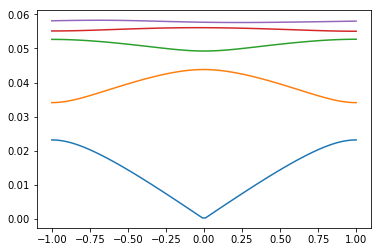

In [104]:
plt.plot(K*l0/np.pi,w0**0.5*10**(-9))
plt.plot(K*l0/np.pi,wm1**0.5*10**(-9))
plt.plot(K*l0/np.pi,w1**0.5*10**(-9))
plt.plot(K*l0/np.pi,wm2**0.5*10**(-9))
plt.plot(K*l0/np.pi,w2**0.5*10**(-9))
plt.show()

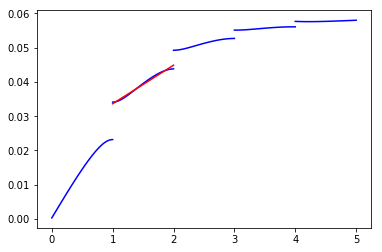

In [106]:
Kext = np.linspace(0,np.pi/l0,50)
w0e = w0[50:]**0.5*10**(-9)
w1e = wm1[0:50]**0.5*10**(-9)
w2e = w1[50:]**0.5*10**(-9)
w3e = wm2[0:50]**0.5*10**(-9)
w4e = w2[50:]**0.5*10**(-9)

fit = np.polyfit((Kext + np.pi/l0)*l0/np.pi,w1e,1)   #Linear fit over the band we want to operate
z = np.poly1d(fit)

plt.plot(Kext*l0/np.pi,w0e,'b')
plt.plot((Kext + np.pi/l0)*l0/np.pi, w1e,"b")
plt.plot((Kext + 2*np.pi/l0)*l0/np.pi, w2e,"b")
plt.plot((Kext + 3*np.pi/l0)*l0/np.pi, w3e,"b")
plt.plot((Kext + 4*np.pi/l0)*l0/np.pi, w4e,"b")
plt.plot(((Kext + np.pi/l0))*l0/np.pi,z((Kext + np.pi/l0)*l0/np.pi),"r")
plt.show()